In [ ]:
from surprise.model_selection import train_test_split, KFold

# 1. Importing & EDA (Pandas)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ratings_df = pd.read_csv('data/ratings.csv')
ratings_df.drop('timestamp', axis=1, inplace=True)

In [3]:
print('Number of Users = ', len(ratings_df['userId'].unique()))
print('Number of Movies = ', len(ratings_df['movieId'].unique()))
print(ratings_df.shape)

Number of Users =  610
Number of Movies =  9724
(100836, 3)


In [4]:
ratings_df.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


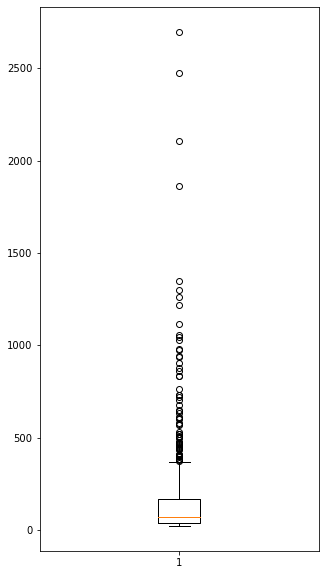

In [5]:
user_rating_count = ratings_df['userId'].value_counts()

fig, ax = plt.subplots(figsize=(5,10))
plt.boxplot(user_rating_count);

In [6]:
user_rating_count

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
406      20
595      20
569      20
431      20
442      20
Name: userId, Length: 610, dtype: int64

# 2. Exploring Model-Based Methods 

1. I am choosing a model-based method over memory-based methods due to the size (100,000 entries) of the dataset
2. I will start by building a Collaborative Filtering recommender system
    - Predictor algorithm will be chosen upon the lowest RMSE score 

In [7]:
import numpy as np
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold
from surprise.prediction_algorithms import BaselineOnly, SVD, SVDpp, NMF, SlopeOne, CoClustering

In [8]:
reader = Reader()
data = Dataset.load_from_df(ratings_df, reader)

In [ ]:
def predictor_RMSE(pred, data, cv=None, njobs=0):
    """
    if 'cv' parameter not specified, cv = 5
    
    """
    pred_base = pred()
    cv_pred = cross_validate(pred_base, data, cv=cv, n_jobs=njobs)
    
    print(np.mean(cv_pred['test_rmse']))
    
    

In [ ]:
predictor_RMSE(BaselineOnly, data, njobs=-1)

In [ ]:
predictor_RMSE(SVD, data, njobs=-1)

In [ ]:
# predictor_RMSE(SVDpp, data, njobs=-1)

In [ ]:
predictor_RMSE(NMF, data, njobs=-1)

In [ ]:
predictor_RMSE(SlopeOne, data, njobs=-1)

In [ ]:
predictor_RMSE(CoClustering, data, njobs=-1)

**OBSERVATION**
1. BaselineOnly and SVD continuously get very close results, with the lower of the two alternating constantly
2. BaselineOnly (along with all other baselines included in Surprise) use ALS as the default
    - this could explain the baseline's comparable results to SVD

### Optimizing SVD

In [ ]:
param_grid = {'n_factors':[50, 100, 150],
              'n_epochs': [10, 20, 30]}

svd_grid = GridSearchCV(SVD, param_grid=param_grid, n_jobs=-1)
svd_grid.fit(data)

In [ ]:
print(svd_grid.best_score)
print(svd_grid.best_params)

In [ ]:
param_grid = {'n_factors':[10, 25, 50],
              'lr_all': [0.002, 0.005],
              'reg_all': [0.02, 0.1, 0.2]}

svd_grid = GridSearchCV(SVD, param_grid=param_grid, n_jobs=-1)
svd_grid.fit(data)

In [ ]:
print(svd_grid.best_score)
print(svd_grid.best_params)

# 3. Making Predictions 

In [ ]:
dataset = data.build_full_trainset()

In [ ]:
dataset = data.build_full_trainset()

svd = SVD(n_factors=10, lr_all = 0.005, reg_all=0.02)
svd.fit(dataset)

In [ ]:
svd.predict(5, 10)

# 3. Recommendations For Preexisting Users

# 4. Addressing 'Cold-Start' Problem

In [9]:
#importing movie titles
title_df = pd.read_csv('data/movies.csv')

#merging ratings and titles
title_rating_df = pd.merge(ratings_df, title_df, on='movieId')

#creating groupby by title and genres
rating_count_df = title_rating_df.groupby(by=['title', 'genres', 'movieId'])

#aggregating the number of ratings for each title 
rating_count_df= rating_count_df['rating'].count().reset_index().rename(columns = {'rating': 'rating_count'})

#display in descending order based on rating_count
rating_count_df = rating_count_df.sort_values(by='rating_count', ascending=False)

#SOURCE FOR CODE
#https://www.youtube.com/watch?v=kccT0FVK6OY&list=PL-IOEPSNs4rYKHhicQ210AXk5yuzrkeH1&index=12&ab_channel=KrishNaik

In [50]:
rating_count_top20 = rating_count_df.head(25)

In [51]:
import seaborn as sns

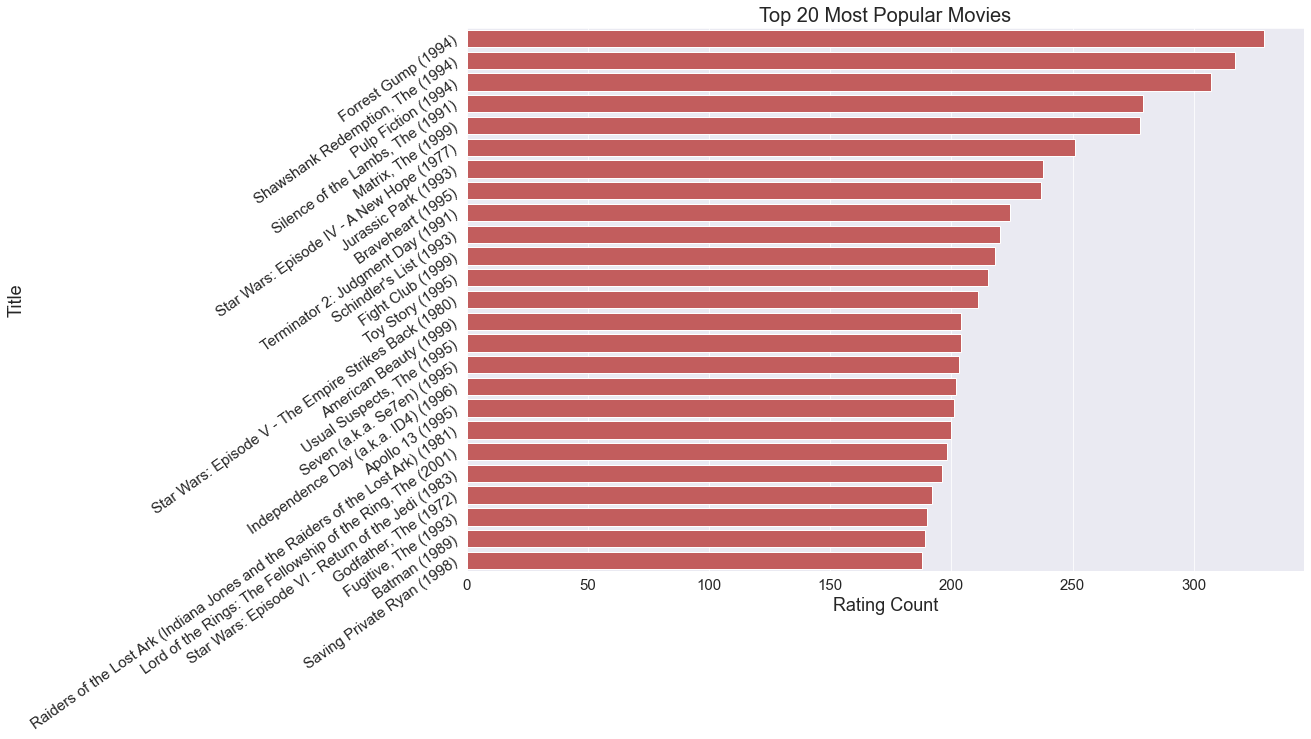

In [86]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(15,10))
ax = sns.barplot(x='rating_count', y='title', data=rating_count_top20,
                color='#d34c4cff')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Title', fontsize=18)
plt.xlabel('Rating Count', fontsize=18)
plt.title('Top 20 Most Popular Movies', fontsize=20)


for item in ax.get_yticklabels():
    item.set_rotation(35)
    
plt.savefig('./images/popular_movies.png', bbox_inches='tight')

In [30]:
def movie_rater():
    userId = ratings_df['userId'].max() + 1
    rating_list = []

        #collecting genre preferences
        #DISPLAY A LIST OF ALL GENRES AVAILABLE? 
    top_genres = []
    top_genres.append(input('What is your favorite movie genre?'))
    top_genres.append(input('What is your SECOND favorite movie genre?'))
    least_fav_genre = input('What is your LEAST favorite movie genre?')

    print('----------------------------------------------')
    print('You will now be shown 5 {} and {} movies, please rate them from 0.5 - 5'.format(top_genres[0], top_genres[1]))
    print('If you have not seen the given movie, please enter n')

        #Prompting the user to rate 5 MOST VIEWED movies of their preferred genres
    num = 5
    index = 0
    while num > 0:
            movie_df = rating_count_df[(rating_count_df['genres'].str.contains(top_genres[0])) 
                                    & (rating_count_df['genres'].str.contains(top_genres[1]))]
            movie_df = movie_df[(~movie_df['genres'].str.contains(least_fav_genre))]
            print('----------------------------------------------')

            movie = movie_df.iloc[index]
            print(movie)
            while True:
                try:
                    rating = input('Please rate this movie 0.5 - 5 /OR/ press n if you have not seen it')
                    while rating.isnumeric:
                        if (float(rating) < 0.5 or float(rating) > 5):
                            rating = input('INVALID RATING : Your rating must be inbetween 0.5 and 5')
                        else: 
                            rated_movie = {'userId':userId, 'movieId':movie['movieId'], 'rating':rating}
                            rating_list.append(rated_movie)
                            num -= 1
                            index += 1
                            break
                    break
                except ValueError:
                    while rating != 'n':
                        rating = input('INVALID RESPONSE : You must enter n if you have not seen this movie')
                    index += 1
                    break



    #adding new user ratings (rating_list) to original ratings dataframe (ratings_df)
    ratings_df = ratings_df.append(rating_list, ignore_index=True)

    new_data = Dataset.load_from_df(ratings_df, reader)

        #training new model on updated_ratings_df
    svd = SVD(n_factors=10, lr_all = 0.005, reg_all=0.02)
    svd.fit(new_data.build_full_trainset())


        #running model to predict new movies for user 

    movie_recs = []
    for m_id in ratings_df['movieId'].unique():
            movie_recs.append( (m_id,svd.predict(500,m_id)[3]))

    print('----------------------------------------------')

    print('We made 5 recommendations for you!')

    ranked_movies = sorted(movie_recs, key=lambda x:x[1], reverse=True)


    #displaying 5 recommendations
    n = 5
    rec_list = []
    for idx, rec in enumerate(ranked_movies):
            title = title_df.loc[title_df['movieId'] == int(rec[0])]['title']
            rec_list.append(title)
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n -= 1
            if n == 0:
                break

    #creating new ranked movies variable for while loop 
    loop_ranked_movies = ranked_movies
    print('----------------------------------------------')


    # ROUND 2 RATINGS --------------------------------------------------------------------            
    pruned_df = pd.DataFrame(loop_ranked_movies)
    drop_list= []

    continue_ = None
    while continue_ == None:
        print('----------------------------------------------')
        print('Would you like to continue rating for more tailored suggestions?')
        
        next_round = input('Please enter y (YES) or n (NO)')
        
        if next_round == 'n':
            break

        #creating a list of recommended movies
        # each entry is a dictionary consisting of the movieId and the title
        #top 50 recommended movies are added to ensure the user can rate 5 before recommendations run out 
        total_rec_list = []
        for i in range(50):

            title_title = title_df[title_df['movieId'] == pruned_df.iloc[i][0]]
            rec_dict = {'movieId': pruned_df.iloc[i][0], 'title': title_title['title']}
            rec_dict_copy = rec_dict.copy()
            total_rec_list.append(rec_dict_copy)


        #creating a list of newly rated movies from the total_rec_list 
        rating_list = []
        num = 5
        index = 0
        while num > 0:
                print('----------------------------------------------')
                movie = total_rec_list[index]['title']
                print(movie)
                while True:
                    try:
                        rating = input('Please rate this movie 0.5 - 5 /OR/ press n if you have not seen it')
                        while rating.isnumeric:
                            if (float(rating) < 0.5 or float(rating) > 5):
                                rating = input('INVALID RATING : Your rating must be inbetween 0.5 and 5')
                            else: 
                                rated_movie = {'userId':userId, 
                                               'movieId': title_df.iloc[movie.index]['movieId'], 
                                               'rating':rating}
                                rating_list.append(rated_movie)
                                num -= 1
                                index += 1
                                break
                        break
                    except ValueError:
                        while rating != 'n':
                            rating = input('INVALID RESPONSE : You must enter n if you have not seen this movie')
                        index += 1
                        break

        #adding ID's of recommended movies to a list to be dropped to prevent duplicated recommendations
        #drop_list must be outside of the recommendation while loop in order to retain what movies have already been recommended
        for i in range(len(rating_list)):
            drop_list.append(int(rating_list[i]['movieId']))

        #adding new ratings to ratings_df
        ratings_df = ratings_df.append(rating_list, ignore_index=True)

        new_data = Dataset.load_from_df(ratings_df, reader)

        #training new model on updated_ratings_df
        svd = SVD(n_factors=10, lr_all = 0.005, reg_all=0.02)
        svd.fit(new_data.build_full_trainset())


        #running model to predict new movies for user 
        movie_recs = []
        for m_id in ratings_df['movieId'].unique():
                movie_recs.append( (m_id,svd.predict(500,m_id)[3]))


        #ordering by predicted ratings
        loop_ranked_movies = sorted(movie_recs, key=lambda x:x[1], reverse=True)

        #removing already recommended movies
        pruned_df = pd.DataFrame(loop_ranked_movies) 

        for idx, col in pruned_df.iterrows():
            if col[0] in drop_list:
                pruned_df.drop(idx, inplace=True)


        print('----------------------------------------------')
        print('We made 5 recommendations for you!')

        #displaying 5 recommendations
        n = 5
        rec_list = []
        for idx, rec in pruned_df.iterrows():
                title = title_df.loc[title_df['movieId'] == int(rec[0])]['title']
                rec_list.append(title)
                print('Recommendation # ', idx+1, ': ', title, '\n')
                n -= 1
                if n == 0:
                    break
        continue

In [31]:
movie_rater()

UnboundLocalError: local variable 'ratings_df' referenced before assignment

In [24]:
ratings_df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [26]:
movie_rater()

What is your favorite movie genre?Action
What is your SECOND favorite movie genre?Horror
What is your LEAST favorite movie genre?Drama
----------------------------------------------
You will now be shown 5 Action and Horror movies, please rate them from 0.5 - 5
If you have not seen the given movie, please enter n
----------------------------------------------
title                            Aliens (1986)
genres          Action|Adventure|Horror|Sci-Fi
movieId                                   1200
rating_count                               126
Name: 333, dtype: object
Please rate this movie 0.5 - 5 /OR/ press n if you have not seen it1
----------------------------------------------
title             Jaws (1975)
genres          Action|Horror
movieId                  1387
rating_count               91
Name: 4534, dtype: object
Please rate this movie 0.5 - 5 /OR/ press n if you have not seen it2
----------------------------------------------
title                                         M

In [27]:
ratings_df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [38]:
def movie_rater():
    userId = ratings_df['userId'].max() + 1
    rating_list = []
    

        #collecting genre preferences
        #DISPLAY A LIST OF ALL GENRES AVAILABLE? 
    top_genres = []
    top_genres.append(input('What is your favorite movie genre?'))
    top_genres.append(input('What is your SECOND favorite movie genre?'))
    least_fav_genre = input('What is your LEAST favorite movie genre?')

    print('----------------------------------------------')
    print('You will now be shown 5 {} and {} movies, please rate them from 0.5 - 5'.format(top_genres[0], top_genres[1]))
    print('If you have not seen the given movie, please enter n')

        #Prompting the user to rate 5 MOST VIEWED movies of their preferred genres
    num = 5
    index = 0
    while num > 0:
            movie_df = rating_count_df[(rating_count_df['genres'].str.contains(top_genres[0])) 
                                    & (rating_count_df['genres'].str.contains(top_genres[1]))]
            movie_df = movie_df[(~movie_df['genres'].str.contains(least_fav_genre))]
            print('----------------------------------------------')

            movie = movie_df.iloc[index]
            print(movie)
            while True:
                try:
                    rating = input('Please rate this movie 0.5 - 5 /OR/ press n if you have not seen it')
                    while rating.isnumeric:
                        if (float(rating) < 0.5 or float(rating) > 5):
                            rating = input('INVALID RATING : Your rating must be inbetween 0.5 and 5')
                        else: 
                            rated_movie = {'userId':userId, 'movieId':movie['movieId'], 'rating':rating}
                            rating_list.append(rated_movie)
                            num -= 1
                            index += 1
                            break
                    break
                except ValueError:
                    while rating != 'n':
                        rating = input('INVALID RESPONSE : You must enter n if you have not seen this movie')
                    index += 1
                    break



    #adding new user ratings (rating_list) to original ratings dataframe (ratings_df)
    user_ratings_df = ratings_df.append(rating_list, ignore_index=True)

    new_data = Dataset.load_from_df(user_ratings_df, reader)

        #training new model on updated_ratings_df
    svd = SVD(n_factors=10, lr_all = 0.005, reg_all=0.02)
    svd.fit(new_data.build_full_trainset())


        #running model to predict new movies for user 

    movie_recs = []
    for m_id in ratings_df['movieId'].unique():
            movie_recs.append( (m_id,svd.predict(500,m_id)[3]))

    print('----------------------------------------------')

    print('We made 5 recommendations for you!')

    ranked_movies = sorted(movie_recs, key=lambda x:x[1], reverse=True)


    #displaying 5 recommendations
    n = 5
    rec_list = []
    for idx, rec in enumerate(ranked_movies):
            title = title_df.loc[title_df['movieId'] == int(rec[0])]['title']
            rec_list.append(title)
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n -= 1
            if n == 0:
                break

    #creating new ranked movies variable for while loop 
    loop_ranked_movies = ranked_movies
    print('----------------------------------------------')


    # ROUND 2 RATINGS --------------------------------------------------------------------            
    pruned_df = pd.DataFrame(loop_ranked_movies)
    drop_list= []

    continue_ = None
    while continue_ == None:
        print('----------------------------------------------')
        print('Would you like to continue rating for more tailored suggestions?')
        
        next_round = input('Please enter y (YES) or n (NO)')
        
        if next_round == 'n':
            break

        #creating a list of recommended movies
        # each entry is a dictionary consisting of the movieId and the title
        #top 50 recommended movies are added to ensure the user can rate 5 before recommendations run out 
        total_rec_list = []
        for i in range(50):

            title_title = title_df[title_df['movieId'] == pruned_df.iloc[i][0]]
            rec_dict = {'movieId': pruned_df.iloc[i][0], 'title': title_title['title']}
            rec_dict_copy = rec_dict.copy()
            total_rec_list.append(rec_dict_copy)


        #creating a list of newly rated movies from the total_rec_list 
        rating_list = []
        num = 5
        index = 0
        while num > 0:
                print('----------------------------------------------')
                movie = total_rec_list[index]['title']
                print(movie)
                while True:
                    try:
                        rating = input('Please rate this movie 0.5 - 5 /OR/ press n if you have not seen it')
                        while rating.isnumeric:
                            if (float(rating) < 0.5 or float(rating) > 5):
                                rating = input('INVALID RATING : Your rating must be inbetween 0.5 and 5')
                            else: 
                                rated_movie = {'userId':userId, 
                                               'movieId': title_df.iloc[movie.index]['movieId'], 
                                               'rating':rating}
                                rating_list.append(rated_movie)
                                num -= 1
                                index += 1
                                break
                        break
                    except ValueError:
                        while rating != 'n':
                            rating = input('INVALID RESPONSE : You must enter n if you have not seen this movie')
                        index += 1
                        break

        #adding ID's of recommended movies to a list to be dropped to prevent duplicated recommendations
        #drop_list must be outside of the recommendation while loop in order to retain what movies have already been recommended
        for i in range(len(rating_list)):
            drop_list.append(int(rating_list[i]['movieId']))

        #adding new ratings to ratings_df
        user_ratings_df = user_ratings_df.append(rating_list, ignore_index=True)

        new_data = Dataset.load_from_df(ratings_df, reader)

        #training new model on updated_ratings_df
        svd = SVD(n_factors=10, lr_all = 0.005, reg_all=0.02)
        svd.fit(new_data.build_full_trainset())


        #running model to predict new movies for user 
        movie_recs = []
        for m_id in ratings_df['movieId'].unique():
                movie_recs.append( (m_id,svd.predict(500,m_id)[3]))


        #ordering by predicted ratings
        loop_ranked_movies = sorted(movie_recs, key=lambda x:x[1], reverse=True)

        #removing already recommended movies
        pruned_df = pd.DataFrame(loop_ranked_movies) 

        for idx, col in pruned_df.iterrows():
            if col[0] in drop_list:
                pruned_df.drop(idx, inplace=True)


        print('----------------------------------------------')
        print('We made 5 recommendations for you!')
        #displaying 5 recommendations
        n = 5
        rec_list = []
        for idx, rec in pruned_df.iterrows():
                title = title_df.loc[title_df['movieId'] == int(rec[0])]['title']
                rec_list.append(title)
                print('Recommendation # ', idx+1, ': ', title, '\n')
                n -= 1
                if n == 0:
                    break
        continue

In [39]:
movie_rater()

What is your favorite movie genre?Action
What is your SECOND favorite movie genre?Sci-Fi
What is your LEAST favorite movie genre?Horror
----------------------------------------------
You will now be shown 5 Action and Sci-Fi movies, please rate them from 0.5 - 5
If you have not seen the given movie, please enter n
----------------------------------------------
title               Matrix, The (1999)
genres          Action|Sci-Fi|Thriller
movieId                           2571
rating_count                       278
Name: 5515, dtype: object
Please rate this movie 0.5 - 5 /OR/ press n if you have not seen it4.5
----------------------------------------------
title           Star Wars: Episode IV - A New Hope (1977)
genres                            Action|Adventure|Sci-Fi
movieId                                               260
rating_count                                          251
Name: 8005, dtype: object
Please rate this movie 0.5 - 5 /OR/ press n if you have not seen it3
----------

In [35]:
user_ratings_df

NameError: name 'user_ratings_df' is not defined